Based on this Medium article:

https://medium.com/wwblog/time-series-clustering-based-on-autocorrelation-using-python-94d5e3475179

In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pandas statsmodels matplotlib scikit-learn

In [4]:
from statsmodels.tsa.arima_process import ArmaProcess
import pandas
import matplotlib.pyplot as plt

processes = [
    ArmaProcess.from_coeffs([], []),       # White noise
    ArmaProcess.from_coeffs([-0.5], []),   # AR(1) 
    ArmaProcess.from_coeffs([], [0.9]),    # MA(1)
    ArmaProcess.from_coeffs([0.5], [0.5])  # ARMA(1, 1)
]

# Now we have four DGPs (data generating processes), so we can use them to sample data.

# Number of time series per process
series_per_process = 3

# Length of an individual time series
T = 1_000

n_processes = len(processes)
n_series = n_processes * series_per_process

# Generate the time series.
df = pandas.DataFrame({
    f'TS_{i}': processes[i // series_per_process].generate_sample(T)
    for i in range(n_series)
})

df

,TS_0,TS_1,TS_2,TS_3,TS_4,TS_5,TS_6,TS_7,TS_8,TS_9,TS_10,TS_11
0,0.762162,1.018150,0.267788,0.840559,0.106449,1.050587,-2.926748,-1.167122,0.640242,-1.671339,0.768614,-0.154157
1,0.745182,0.602841,-0.374446,-1.196761,0.334425,-0.011736,-4.451655,-1.779259,0.284883,0.016403,0.059888,-0.942496
2,-1.556220,0.528610,0.964079,-0.850071,0.939768,1.976725,-1.719584,-2.007923,-0.814406,0.881322,-0.915863,1.287491
3,-1.063797,-1.234617,0.416979,2.312058,-2.042146,-1.233426,-0.307506,-1.909552,-0.209337,2.983707,-0.520842,-0.174834
4,-0.287067,0.975225,0.272581,-2.183657,1.736646,0.363502,0.115798,-0.060021,-0.898997,1.939729,0.157921,-1.947312
...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.865481,-1.525544,0.736701,0.556710,1.637652,1.004523,1.108280,-2.426569,-0.566420,-4.174113,2.087264,1.166213
996,-1.530378,1.099131,0.060214,0.012754,-0.906837,0.128304,-0.498383,1.727789,-0.402094,-2.336548,0.587453,-0.102947
997,0.783948,0.097464,-0.908388,-0.417030,0.015296,0.234351,-0.857174,1.707204,1.167742,0.105722,-0.059509,0.620752
998,-0.165461,-0.399844,1.126778,1.440070,-0.286233,2.158341,0.028273,-0.041279,1.441364,-0.134581,-0.856325,2.197505


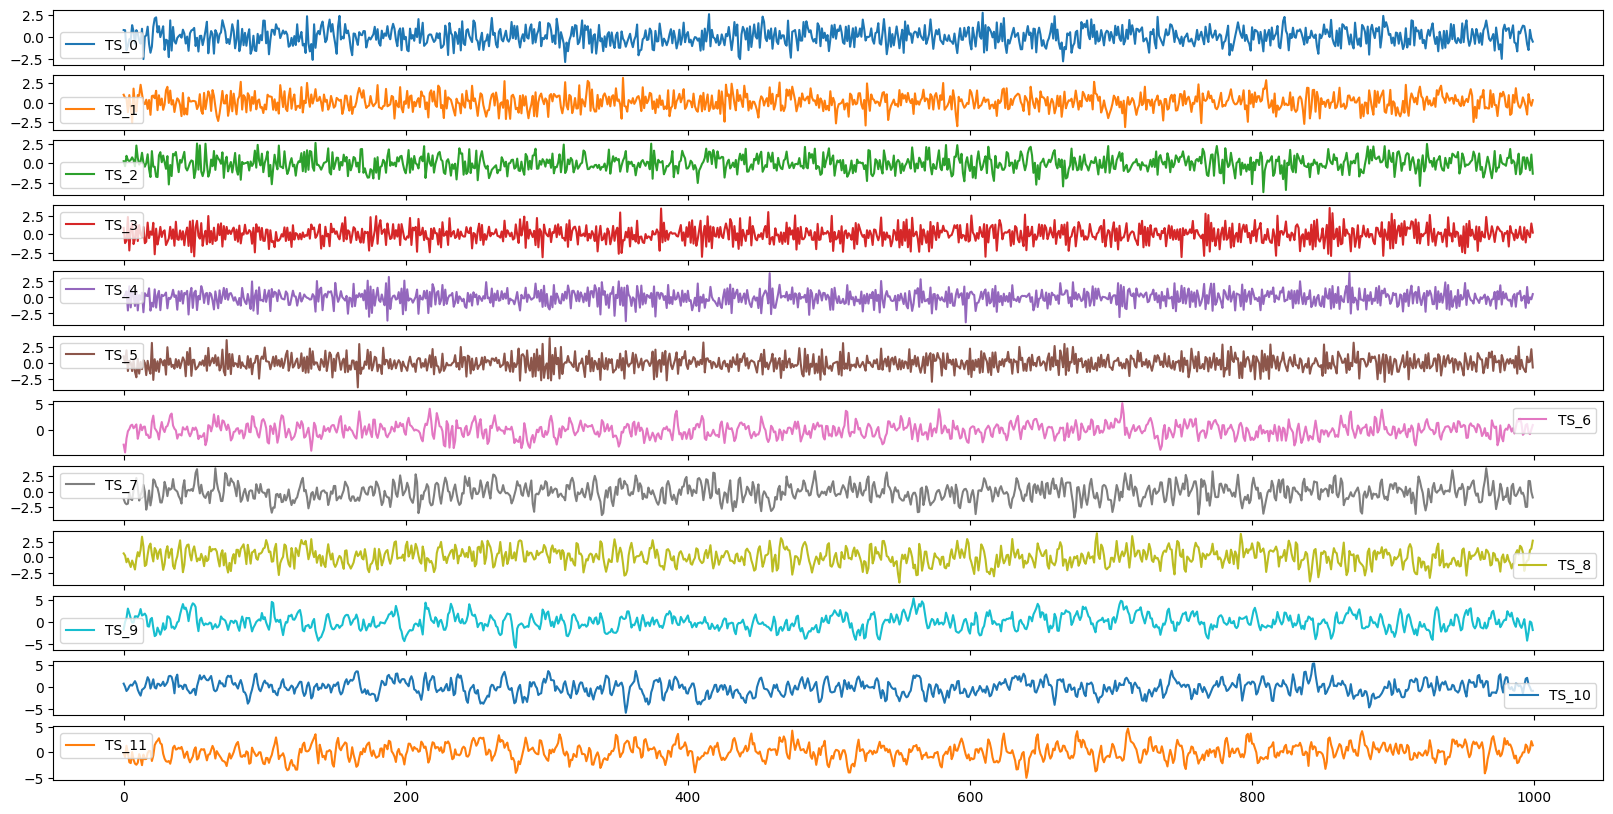

In [8]:
df.plot(subplots=True, figsize=(20, 10))
_ = plt.legend(loc='best')

## Autocorrelation function (ACF)

For a given time series and a lag - the number of time steps between two values in the series - there's a set of all value pairs having that lag between them.
A lag of 3 has pairs `{(t=0, t=3), (t=1, t=4), (t=2, t=5), ...}`.
You can measure the correlation of time series values for that set, which yields an informative statistic reguarding the time series.

For any given series, the function that maps the lags `L >= 0` to their corresponding correlations is called the autocorrelation function.
It is a vector, and we can estimate it from sample data.

In [10]:
import statsmodels.tsa.stattools
import numpy as np
import pandas as pd

def acf(x, n_lags):
    return statsmodels.tsa.stattools.acf(x, nlags=n_lags)

# Max ACF lags, those that we care about for the feature vector
n_lags = 20

lag_arr = np.repeat(n_lags, df.shape[1])

acf_list = list(map(
    acf,
    df.transpose().to_numpy(),
    lag_arr
))

acf_df = pd.DataFrame(acf_list).transpose()
acf_df.columns = df.columns
acf_df


,TS_0,TS_1,TS_2,TS_3,TS_4,TS_5,TS_6,TS_7,TS_8,TS_9,TS_10,TS_11
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,-0.004053,-0.041332,0.003074,-0.513915,-0.492328,-0.470068,0.475061,0.485882,0.464265,0.735582,0.716786,0.691576
2,-0.014705,-0.001259,-0.006286,0.265660,0.248629,0.205790,-0.016252,-0.032068,-0.017227,0.403167,0.358096,0.318508
3,-0.000588,-0.024472,-0.012122,-0.097910,-0.103077,-0.123678,0.044785,-0.046903,0.021693,0.235078,0.204106,0.148310
4,-0.033151,-0.040154,-0.025867,0.027956,0.027813,0.050955,0.030582,-0.025409,-0.012811,0.135337,0.145965,0.060914
5,0.005788,-0.010642,-0.035315,-0.038947,-0.010188,-0.010269,0.004706,0.007127,-0.030032,0.074144,0.099863,0.013445
6,-0.045555,-0.004556,0.020500,0.023735,-0.026419,0.031468,0.073830,0.009910,0.015042,0.063448,0.063897,-0.019303
7,-0.010052,0.056113,0.001049,0.019199,0.058237,0.003241,0.076102,0.039103,0.041142,0.068020,0.026263,-0.063235
8,-0.013363,-0.025140,0.002761,-0.030784,-0.036533,-0.015277,-0.024390,0.054245,0.003518,0.063856,0.007203,-0.089018
9,0.003236,0.033311,0.009432,0.050566,0.026294,0.034929,-0.045993,0.016910,-0.020253,0.059462,0.025530,-0.093249


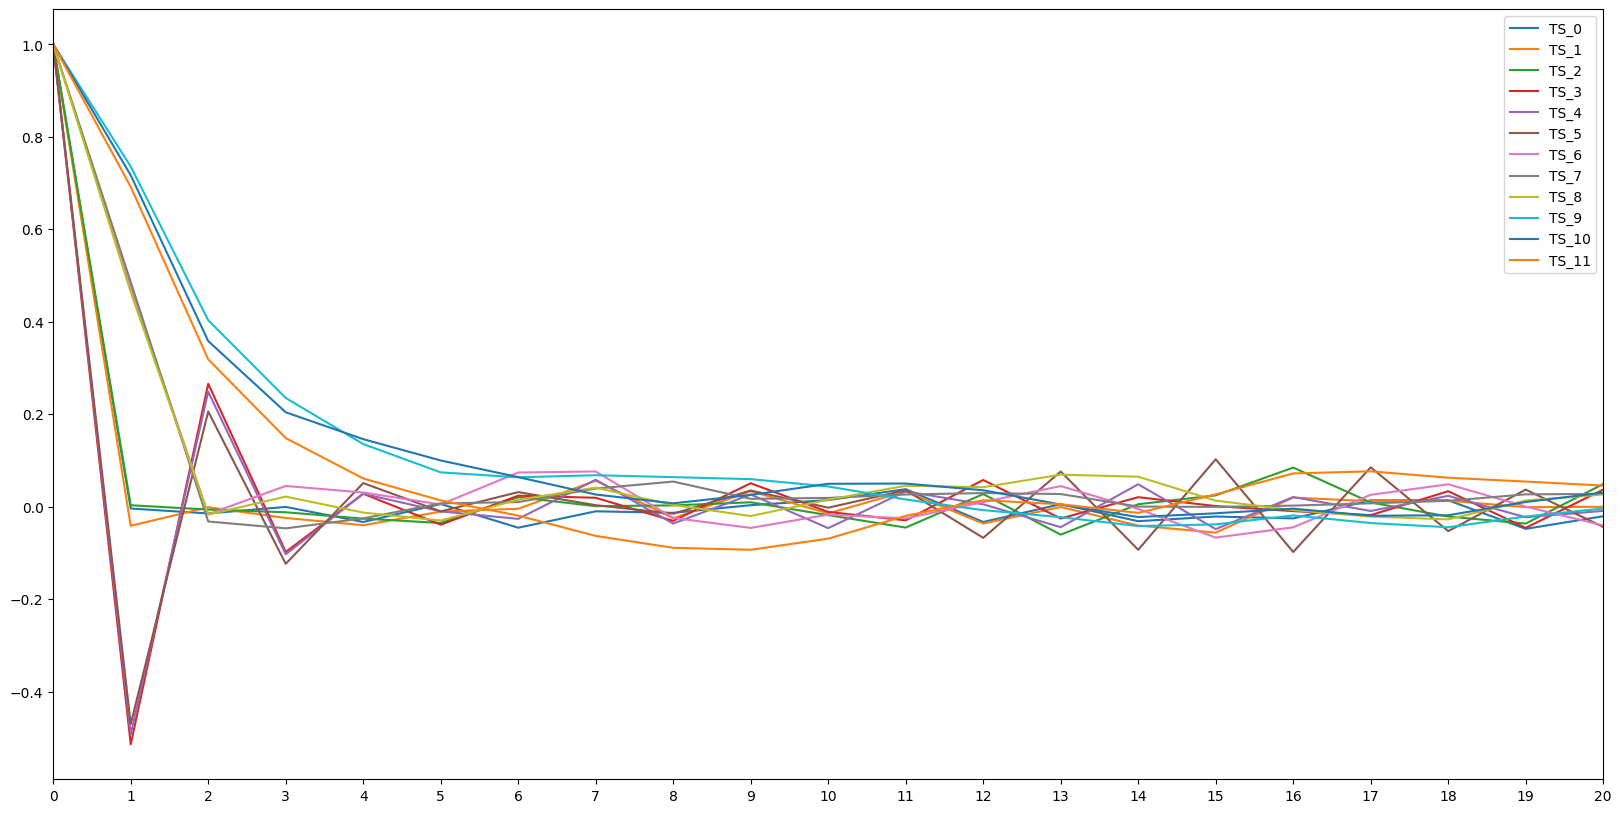

In [16]:
axes = acf_df.plot(figsize=(20, 10))
axes.set_xlim(left=0, right=acf_df.shape[0]-1)
axes.set_xticks(range(acf_df.shape[0]))
_ = plt.legend(loc='best')


There are four distinct clusters based on this plot at the lower lag values.
Notice how at `l=1`, there are four line groups, each with lines very close to each other and distinctively far away from other line groups.
This makes sense considering we employed four distinct DGPs.

The line group at `(x = 1, y ~= 0)` ought to correspond to the white noise DGPs since it hovers around 0, suggesting uncorrelated values.

It turns out that both autoregression (AR) and moving averages (MA) induce autocorrelation, so the other three clusters correspond to those.

## Clustering the Time Series Computationally

Let's use *k*-means clustering.
We are kind of cheating by knowing the value of *k*, but this can be resolved in the future by looking at clustering indices for varying values of *k*.

In [23]:
from sklearn.cluster import KMeans

n_clusters = n_processes
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')\
    .fit(acf_df.transpose())

kmeans.labels_

array([2, 2, 2, 1, 1, 1, 0, 0, 0, 3, 3, 3], dtype=int32)

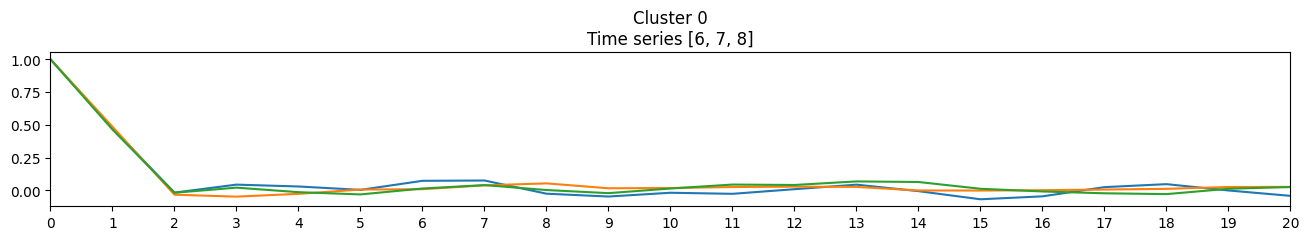

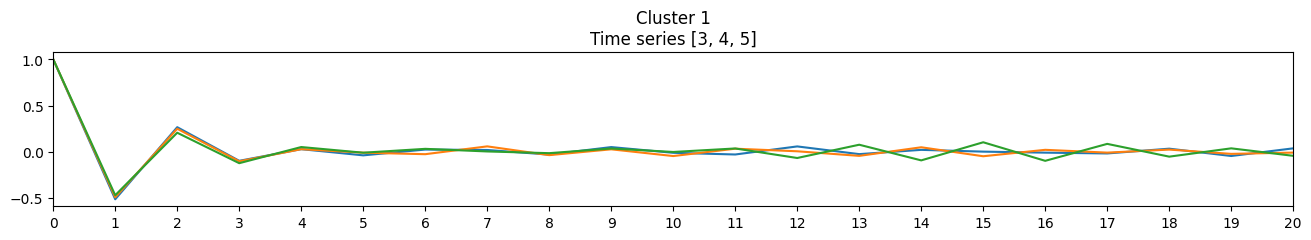

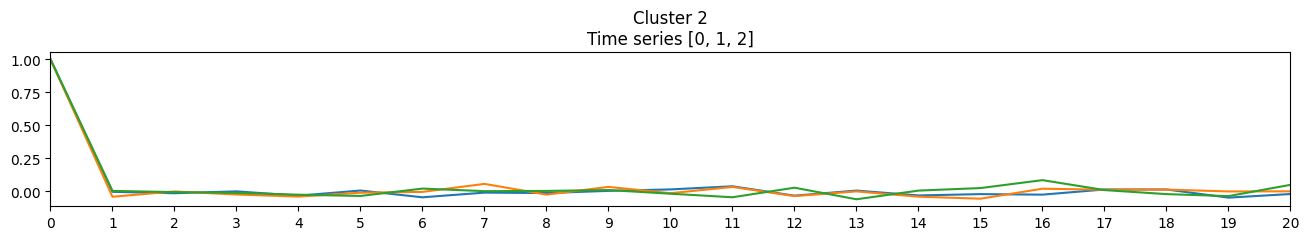

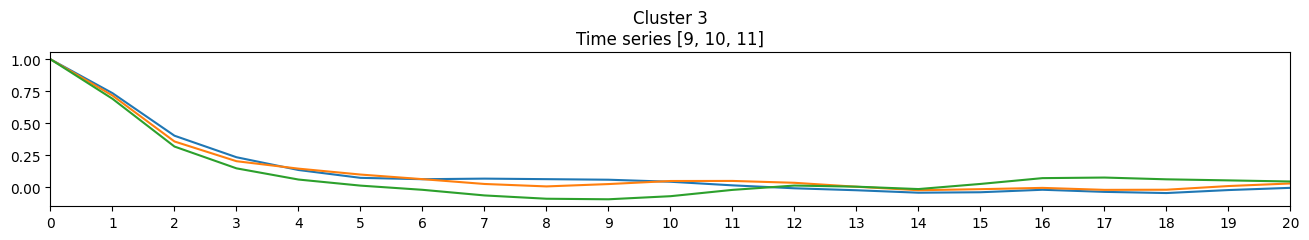

In [28]:
# i ranges over clusters
for i in range(n_clusters):
    plt.figure(figsize=(16, 2))
    plt.xlim((1, n_lags))

    ts = []
    
    # j ranges over the series ACFs
    for j in range(n_series):
        
        # Plot ACF j in the current cluster i
        if kmeans.labels_[j] == i:
            ts.append(j)
            plt.plot(acf_df.iloc[:, j])
            plt.xticks(range(acf_df.shape[0]))

        plt.title(f"Cluster {i}\nTime series {ts}")
        
plt.show()

So, we've clustered some time series using ACF estimates as a feature vector, and using *k*-means to perform the clustering.
There are some alternatives:

* Sticking with features, some other time-domain features such as PACF, quantile auto covariance, and others
* Frequency-domain or wavelet-domain features are feasible too
* Features are not necessary; there are observation-based and model-based clustering too
* Other distance measures besides Euclidean may be appropriate
* Crisp or fuzzy clustering is doable

See "Time Series Clustering and Classification" by Maharaj et. al.